In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os, sys, subprocess, json, argparse
from itertools import product
from collections import defaultdict

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

dir_root = '.'
# If using google colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')
    dir_root = '/content/drive/MyDrive/Colab Notebooks/ESE546/hw4'

print("dir_root:", dir_root)

device: cuda
dir_root: .


In [3]:
# Download the MNIST dataset (skip if already exists)
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
print(train_dataset.data.shape)
print(test_dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [4]:
# Create dictionaries to store indices for each digit
digit_to_indices = defaultdict(list)

# Get indices for each digit in the training set
for idx, (_, label) in enumerate(train_dataset):
    digit_to_indices[label].append(idx)

# Extract 1000 images per digit and subsample to 14x14
images_per_digit = 1000
target_size = 14
extracted_images = {}
extracted_labels = {}

for digit in range(10):
    # Randomly sample 1000 indices for this digit
    selected_indices = np.random.choice(digit_to_indices[digit], images_per_digit, replace=False)
    
    digit_images = []
    digit_labels = []
    
    for idx in selected_indices:
        image, label = train_dataset[idx]
        # Subsample image to 14x14
        # Add batch dimension for F.interpolate
        image = image.unsqueeze(0)
        image = F.interpolate(image, size=(target_size, target_size), mode='bilinear', align_corners=False)
        image = image.squeeze(0)
        
        digit_images.append(image)
        digit_labels.append(label)
    
    # Stack the images and labels
    extracted_images[digit] = torch.stack(digit_images)
    extracted_labels[digit] = torch.tensor(digit_labels)

# Combine all digits into single tensors
all_images = torch.cat([extracted_images[d] for d in range(10)])  # Shape: [10000, 1, 14, 14]
all_labels = torch.cat([extracted_labels[d] for d in range(10)])  # Shape: [10000]

torch.Size([10000, 1, 14, 14])
torch.Size([10000])
Digit 0 has 1000 images
Digit 1 has 1000 images
Digit 2 has 1000 images
Digit 3 has 1000 images
Digit 4 has 1000 images
Digit 5 has 1000 images
Digit 6 has 1000 images
Digit 7 has 1000 images
Digit 8 has 1000 images
Digit 9 has 1000 images


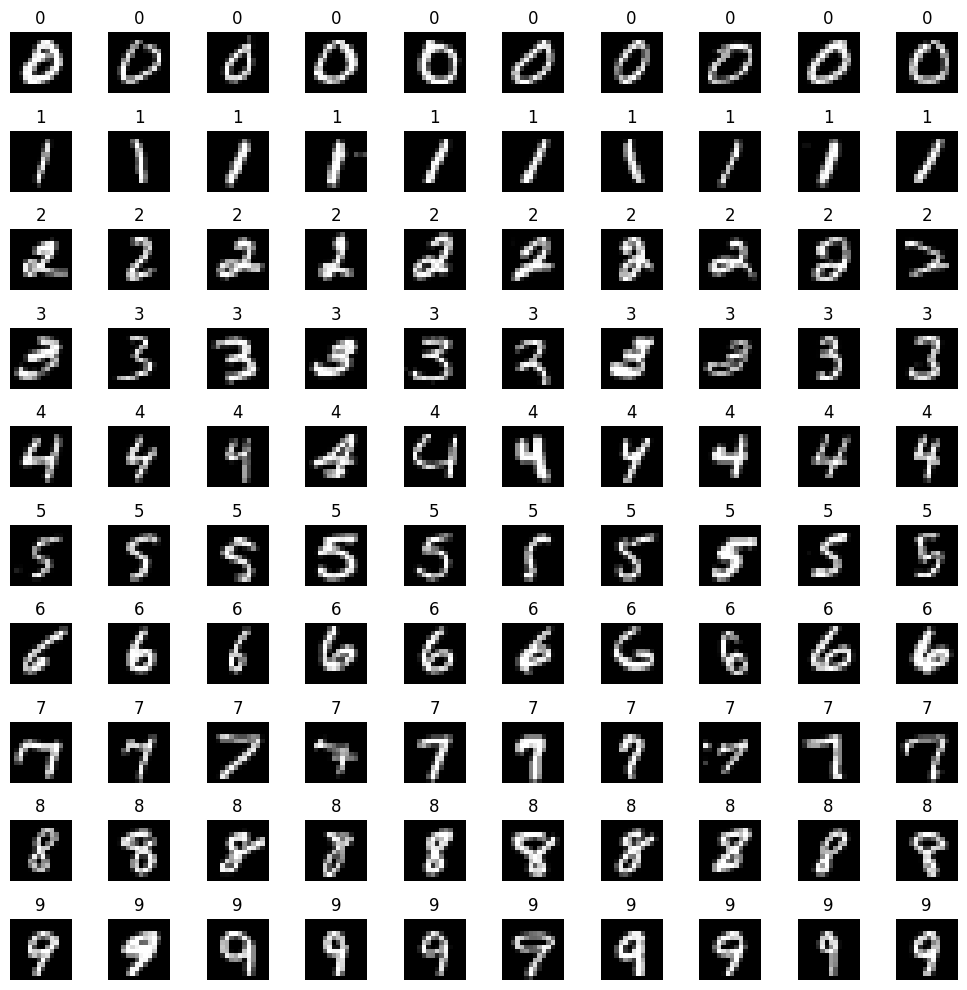

In [5]:
# Validate the dataset

print(all_images.shape)  # Shape: [10000, 1, 14, 14]
print(all_labels.shape)  # Shape: [10000]

# Check if each digit has 1000 images
for digit in range(10):
    num_images = (all_labels == digit).sum().item()
    print(f"Digit {digit} has {num_images} images")

# Randomly visualize 10 images per label to check if labels and images correspond
def visualize_random_images_per_label(images, labels, num_images=10):
    fig, axs = plt.subplots(10, num_images, figsize=(num_images, 10))
    
    for digit in range(10):
        digit_indices = (labels == digit).nonzero(as_tuple=True)[0]
        # Randomly select num_images indices
        selected_indices = np.random.choice(digit_indices, num_images, replace=False)
        
        for i, idx in enumerate(selected_indices):
            axs[digit, i].imshow(images[idx].squeeze(0), cmap='gray')
            axs[digit, i].axis('off')
            axs[digit, i].set_title(labels[idx].item())
    
    plt.tight_layout()
    plt.show()

# Visualize the images and labels
visualize_random_images_per_label(all_images, all_labels)

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder (14x14=196 inputs -> 128 -> 16 for mean and std dev)
        self.encoder_fc1 = nn.Linear(14 * 14, 128)
        self.encoder_fc2 = nn.Linear(128, 16)  # 8 for mean, 8 for std dev
        
        # Decoder (8 -> 128 -> 196 outputs)
        self.decoder_fc1 = nn.Linear(8, 128)
        self.decoder_fc2 = nn.Linear(128, 14 * 14)
        
    def encode(self, x):
        # Flatten the input
        x = x.view(-1, 14 * 14)
        
        h1 = torch.tanh(self.encoder_fc1(x))
        h2 = self.encoder_fc2(h1)
        
        # Split into mean and log_var
        mean = h2[:, :8]
        log_var = h2[:, 8:]
        return mean, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = torch.tanh(self.decoder_fc1(z))
        h4 = torch.sigmoid(self.decoder_fc2(h3))
        
        # Reshape to image dimensions
        return h4.view(-1, 1, 14, 14)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def loss_function(recon_x, x, mu, log_var):
    # Reconstruction loss (binary cross entropy as we're using binarized MNIST)
    BCE = F.binary_cross_entropy(recon_x.view(-1, 14*14), x.view(-1, 14*14), reduction='sum')
    
    # KL divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return BCE + KLD

# Training function
def train_vae(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    return train_loss / len(train_loader.dataset)

# Setup training
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(all_images),
    batch_size=batch_size, shuffle=True)

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
n_epochs = 50
for epoch in range(1, n_epochs + 1):
    train_loss = train_vae(model, train_loader, optimizer, epoch)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Average loss = {train_loss:.4f}')

In [6]:
# Shut down if it's google colab
# First sleep for a while so that changes to the notebook are saved
import time
time.sleep(30)

if 'google.colab' in str(get_ipython()):
    from google.colab import runtime
    runtime.unassign()